# Perzistentna homologija i oblici evelutivnih igara

Ovaj rad se zasniva na [Persistent homology and the shape of evolutionary games, Jakob Stenseke](https://www.sciencedirect.com/science/article/pii/S0022519321003222)

Prostorne igre pružaju mnoge uvide u ponašanje i odnose unutar neke populacije. Znog njihove dinamike, prostorni modeli postaju veoma komplikovani za interpretiranje. Kako bi rešili ovog problema možemo koristiti perzistentnu homologiju kao okvir koji može da definiše i računa osobine višeg reda, koje su pri tome invarijantne na odabir parametara, otporne na šum, i nezavisne od ljudskog opažanja. 

Ovaj rad analizira perzistentnu homologiju igre: zatvorenikova dilema.

# Uvod

**Evolutivna teorija igara** (engl. Evolutionary game theory --- EGT)je primena teorije igara na populaciju koja evoluira. Definiše okvire takmičenja, strategija, i analitike u kojima se takmičenje može modelovati. Evolutivne igre se razlikuju od klasičnih igara jer se fokusiraju na dinamiku promena strategija (reprodukciju) i evolutivno stabilne strategije. To nam omogućava da bolje opišemo kako se strategije menjaju tokom vremena, pod pretpostavkom da se ne koristi savršeni racio (kao što je to slučaj u klasičnoj teoriji igara).

Smatra se da prostorni efekti imaju uticaj na evolutivnu dinamiku, te se istražuju mnoge prostorne igre. Kako prostor tako i evolutivna dinamika (u smislu mutacije, reprodukcije, itd.) utiču na stanje igre.

Pokazuje se da je oblik prostora važan, te se osobine koje obstaju tokom vremena uzimaju kao osobine višeg reda tog prostora. Osobine koje duže obstaju reflektuju stabilnost strategije. Perzistentna homologije pruža metod koji prepoznaje one osobine koji obstaju duže, a da je pritome veoma je otporan na šum.

## Perzistentna homologija primenjena na evolutivne igre

Kod prostornih igara pretpostavljamo da će oblici reflektovati stanje igre, tj. da će oblik biti distribucija strategija u prostoru. Kao primer možemo razmatrati dvodimenzione igre na rešetci sa dve strategije $A$ i $B$. Svako polje $10 \times 10$ rešetke je okupirano nekom strategijom. Analiza trenutnog stanja igre perzistentnom homologijom nam omogućava da automatizujemo intuitivnu analizu tog stanja.

<img src="../results/example_1.png">

Postupak analize perzistentnom homologijom podrazumeva generisanje $\mathcal{VR}$, Vietoris-Ripsovog kompleksa, od skupa tačaka $X$ iz rešetke sa željenom strategijom. Tačnije, skup $X$ sadrži sve one tačke $(x, y)$ za koje važi da su okupirane strategijom $S$, tj. važi $S(x, y)$.
Primenom perzistentne homologije na $\mathcal{VR}$ kompleks možemo izvući parove rađanja i smrti neke osobine. Odatle motivacija pravljenja barkodova koji će predstavljati početak (rađanje) i kraj (smrt) neke osobine.

Pored analize dvodimenzionog prostora, od interesa je analizirati i kako se taj dvodimenzioni prostor menja kroz vreme. Iz toga možemo izvući neku dinamiku evelotivne igre, tj. način na koji se strategije smenjuju tokom vremena. U ovom slučaju, dodajemo još jednu koordinatu koja će predstavljati vreme, te će skup tačaka biti oblika $S(x, y, t)$, što žnači da će polje $(x, y)$ biti okupirano strategijom $S$, u trenutku $t$. 

![2D resetka](../results/states_iter.jpg)

Dodavanjem vremenske dimenzije javljaju se tri oblika od interesa:

1. Struktura u celosti ispunjena jendom strategijom je evolutivno stabilna strategija.
2. Struktura sa $m$ jednodimenzionih rupa je evolutivno stabilna strategija sa $m$ stabilnih klastera jedne ili više drugih strategija unutar sebe.
3. Struktura sa $m$ dvodimenzionih rupa je evolutivno stabilna strategija sa $m$ nestabilnih klastera jedne ili više drugih strategija unutar sebe.

In [69]:
import enum
import random
import copy

import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np

import gudhi

In [70]:
# cooperate => True
# defect => False

## Zatvorenikova dilema

Igra koju mi razmatramo je **zatvorenikova dilema** (engl. *prisoner's dilemma*), u kojoj dva igrača u isto vreme igraju jedan od dva poteza:

*  Cooperate (Da sarađuje sa drugim igračem) 
*  Defect (Da ne sarađuje sa drugim igračem) 

U svakoj iteraciji igraci igraju odredjenu  zavisnosti od toga koju su opciju izabrali, kao i koju je opciju izabrao protivnik, dobiće neki broj bodova. Tako dobijamo matricu bodova u kojoj je svaki element uredjeni par bodova koje dobijaju prvi i drugi igrač, respektivno. Matrica bodova ima sledeći oblik:


| * | Cooperate | Defect |
| - | --- | --- |
| **Cooperate** | (R, R) | (S, T) |
| **Defect** | (T, S) | (P, P) |


*Npr.* ako igrač 1. stavi Cooperate, a igrač 2. Defect, igrač 1. će dobiti $S$ bodova, a 2. $T$ bodova. Vrednost $R, S, T$ i $P$ se određuju na samom početku partije, i obično će vrednosti za $R$ i $T$ pozivitine (ali izabrane tako da $R < T$), $S$ biti negativne, za $P$ ćemo uzeti $0$.

Oba igrača dobijaju neku početnu sumu bodova $SS$, i ako njihova suma postane $\leq 0$, oni su izgubili partiju. Pored toga, postoji i maksimalna suma bodova $MS$, i suma igrača ne sme preći tu vrednost.

## Strategije

Kao rezultat svega ovoga, formiraju se *strategije*, koje će igračima pomoći da budu u prednosti u odnosu na protivnika. Postoji velika količina različitih strategija, ali one koje su korišćene u radu su:
    
1. Defactor (D) - Uvek radi Defect akciju
2. Cooperator (C) - Uvek radi Cooperate akciju
3. Tit-for-tat (TFT) - Prvi potez će mu uvek biti Cooperate, ali svaki sledeći će mu biti akcija koju je prethodni protivnik iskoristio
4. Anti-tit-for-tat (ATFT) - Prvi potez će mu uvek biti Defect, ali svaki sledeći će mu biti suprotna akcija od one koju je prethodni protivnik iskoristio

In [4]:
class TypeOfStrategy(enum.Enum):
    Defactor = 1
    Cooperator = 2
    Tit_for_tat = 3
    Anti_tit_for_tat = 4
    
def chr2strategy(strategy):
    if strategy == 'D':
        return TypeOfStrategy.Defactor
    if strategy == 'C':
        return TypeOfStrategy.Cooperator
    if strategy == 'T':
        return TypeOfStrategy.Tit_for_tat
    if strategy == 'A':
        return TypeOfStrategy.Anti_tit_for_tat
    return None

def strategy2chr(strategy):
    if strategy == TypeOfStrategy.Defactor:
        return 'D'
    if strategy == TypeOfStrategy.Cooperator:
        return 'C'
    if strategy == TypeOfStrategy.Tit_for_tat:
        return 'T'
    if strategy == TypeOfStrategy.Anti_tit_for_tat:
        return 'A'
    return None

Pravimo klasu `Strategy`, koja nam zapravo predstavlja neku od mogućih strategija, i koja ima metod `next_move`, koja će nam dati sledeći potez igrača.

In [5]:
# strategija bira uz pomoc next_move koju ce vrednost nas igrac dati (tj. da li ce coop ili defect)
class Strategy:    
    
    def __init__(self, type_of_strategy):
        self.type_of_strategy = type_of_strategy
        self.previous_move = None
        
    def next_move(self):      
        if self.type_of_strategy == TypeOfStrategy.Cooperator:
            return True
        if self.type_of_strategy == TypeOfStrategy.Defactor:
            return False
        if self.type_of_strategy == TypeOfStrategy.Tit_for_tat:
            if self.previous_move == None:
                return True
            return self.previous_move
        if self.type_of_strategy == TypeOfStrategy.Anti_tit_for_tat:
            if self.previous_move == None:
                return False
            return not self.previous_move 
        
    
    def update_previous_move(self, new_move):
        self.previous_move = new_move
        
    def __str__(self):
        return f"Stg({strategy2chr(self.type_of_strategy)})"

## Igranje igre

Po pitanju formiranja igre, imaćemo $n \times n$ matricu, gde će svaka ćelija predstavljati jednog igrača, sa svojom strategijom i rezultatom. U toku jedne runde, svaki igrač će izabrati jednog od njegovih suseda (u matrici), da odigraju jednu rundu, u kojoj će oba igrača dobiti/izgubiti određenu količinu bodova. Tako će se igra izvršavati, kroz više iteracija, da bismo pratili šta se vremenom dešava (koje su strategije bolje/gore i slično).

*Primer jedne takve matrice* (u ovom slučaju, crveni predstavljaju igrače koji koriste strategiju Defect, a zeleni TFT):

<img src="../results/example_1.png">

## Smrt i mutacija

Sad se postavlja pitanje, šta se dešava ako rezultat nekog igrača bude $\leq 0$ ? Postoje dva slučaja:
    
1. Klasična smrt
2. Mutacija

Klasična smrt nastaje kada igrač ima rezultat $\leq 0$, ili kada nastane smrt od starosti (ubrzo o tome). Pri nastanku smrti, nasumično se bira neki od komšija, od koga će se iskopirati svi njegovi bitni podaci. Naime, imaće istu strategiju kao on, i takođe će kopirati njegov trenutni rezultat.

Mutacija podrazumeva da postoji vrlo mala verovatnoća sa kojom igrač neće umreti na "klasičan način", već će nasumično izabrati neku strategiju, i postaviti rezultat na početnu sumu bodova $SS$. 

Pored toga, postoji i umiranje **od starosti**. U toku igranja igre, posle svake iteracije povećavamo broj godina igrača. Verovatnoća da će igrač umreti od starosti je :
    
$$
\frac{\lambda}{\theta} + 1, \\
{\lambda} - \text{player age} \\
{\theta} - \text{rate of senescence} \\
$$

Ako je $\theta = 10$ i $\lambda = 19$, onda postoji $90\%$ šanse da će umreti. Parametar $\theta$ služi da bi se sprečilo umiranje velike količine igrača u isto vreme.

Sledeća klasa `Player`, nam zapravo predstavlja igrača, u kojoj se nalaze sve vrednosti koje smo spomiljali, kao što su rezultat, početni rezultat, broj godina, šansa da se dogodi mutacija, i slične. Pored njih, postoji i metoda koja će proveriti da li je igrač umro, i ako jeste, izvršava ili *mutaciju*, ili *klasičnu smrt*.

Podrazumevane vrednosti za parametra `mutation_probability` je nula, jer u nekim slučajevima želimo da vidimo kako će se igra odvijati, ako ne postoji mutacija. Slično je `rate_of_senescence` beskonačno, tj. razmatramo igru kada ne postoji umiranje od starosti.

In [6]:
class Player:
    # vrednosti kao rate_of_senescence i max_score su uvek iste, pa neka budu staticke
    rate_of_senescence = float('inf')
    maximum_score = 4
    starting_score = 2
    
    mutation_probability = 0.0
    starting_age = 0
    
    def __init__(self, type_of_strategy, i, j):
        self.strategy = Strategy(type_of_strategy)
        self.age = Player.starting_age
        self.score = Player.starting_score
        self.i = i
        self.j = j
     
    def check_death(self):
        chance_death_old_age = (self.age / Player.rate_of_senescence) - 1 
        if random.random() < chance_death_old_age or self.score <= 0:
            return True
        return False
    
    def reborn(self, neighbours):
        # moguci ishodi:
        # 1) kopira sve od random suseda
        # 2) mutacija => mala verovatnoca, uzima skroz random strategiju, i pocinje ispocetka
        if random.random() < Player.mutation_probability:
            self.mutation()
        else:
            selected_neighbour = random.choice(neighbours)
            self.strategy = Strategy(selected_neighbour.strategy.type_of_strategy)
            self.score = selected_neighbour.score
        self.age = 0
            
    def mutation(self):
        self.strategy = Strategy(TypeOfStrategy(random.randint(1, len(TypeOfStrategy))))
        self.age = Player.starting_age        
        self.score = Player.starting_score
        
    def __str__(self):
        return f"Ply({self.strategy}, Age({self.age}), Scr({self.score}))"


In [7]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

Klasa `Game` će predstavljati odigravanje onoliko rundi koliko je dato kao parametar. Unutar nje, postoji atribut `state` koje predstavlja trenutno stanje igre, kao i niz `all_states` koji čuva sva prethodna stanja, te je pristup nekoj nekoj iteraciji jednostavan (npr. prethodna slika je pokazala stanje igre u prvoj iteraciji). Pored toga, `Game` je odgovoran za interakcije između neka 2 igrača, kao i ažuriranje svojih parametara.

In [8]:
class Game:
    Cooperate = True
    Defect = False
    
    def __init__(self, payoff_values, n=10, initial_state=None, num_of_iterations=10, mutation_rate=0.0, rate_of_senescence=float('inf')):
        self.payoff_matrix = self.__set_payoff_matrix(payoff_values)
        self.n = n if initial_state is None else len(initial_state)
        self.state = self.__process_initial_state(n, initial_state)
        self.all_states = []
        self.num_of_iterations = num_of_iterations
        self.strategy_counter = []
        # svaki put kad kreiramo igru, postavljamo staticku vrednost mut_rate za trenutni game (podrazumevano 0)
        Player.mutation_probability = mutation_rate
        Player.rate_of_senescence = rate_of_senescence
     
    def __set_payoff_matrix(self, payoff_values):
        return {
            (Game.Cooperate, Game.Cooperate) : (payoff_values["R"], payoff_values["R"]),
            (Game.Cooperate, Game.Defect) : (payoff_values["S"], payoff_values["T"]),
            (Game.Defect, Game.Cooperate) : (payoff_values["T"], payoff_values["S"]),
            (Game.Defect, Game.Defect) : (payoff_values["P"], payoff_values["P"])
        }
    
    def __process_initial_state(self, n, initial_state):
        state = []
        
        if initial_state is not None:
            state = [[Player(chr2strategy(strategy), i, j) for j, strategy in enumerate(row)] for i, row in enumerate(initial_state)]
        else:
            state = [[Player(TypeOfStrategy(random.randint(1, 4)), i, j) for j in range(n)] for i in range(n)]
        
        return state
    
    def __neighbours(self, i, j):
        neighbours = []
        if i > 0 and j > 0:
            neighbours.append(self.state[i-1][j-1])
        if i > 0:
            neighbours.append(self.state[i-1][j])
        if i > 0 and j < self.n - 1:
            neighbours.append(self.state[i-1][j+1])
        if j > 0:
            neighbours.append(self.state[i][j-1])
        if j < self.n - 1:
            neighbours.append(self.state[i][j+1])
        if i < self.n - 1 and j > 0:
            neighbours.append(self.state[i+1][j-1])
        if i < self.n - 1:
            neighbours.append(self.state[i+1][j])
        if i < self.n - 1 and j < self.n - 1:
            neighbours.append(self.state[i+1][j+1])
        return neighbours
    
    def __select_neighbour_index(self, i, j):
        indices = []
        if i > 0 and j > 0:
            indices.append((i-1, j-1))
        if i > 0:
            indices.append((i-1, j))
        if i > 0 and j < self.n - 1:
            indices.append((i-1, j+1))
        if j > 0:
            indices.append((i, j-1))
        if j < self.n - 1:
            indices.append((i, j+1))
        if i < self.n - 1 and j > 0:
            indices.append((i+1, j-1))
        if i < self.n - 1:
            indices.append((i+1, j))
        if i < self.n - 1 and j < self.n - 1:
            indices.append((i+1, j+1))
            
        index = random.randint(0, len(indices) - 1)
        
        return indices[index]
    
    def __players_interations(self, player1, player2, neighbours1, neighbours2):
        p1_move = player1.strategy.next_move()
        p2_move = player2.strategy.next_move() 
        player1.strategy.previous_move = p2_move
        player2.strategy.previous_move = p1_move 
        #print(f'Moves: {p1_move}, {p2_move}')
        p1_payoff_value, p2_payoff_value = self.payoff_matrix[(p1_move, p2_move)]
    
        #print(f'Payoff: {p1_payoff_value}, {p2_payoff_value}')
        player1.score = min(Player.maximum_score,  player1.score + p1_payoff_value)
        player2.score = min(Player.maximum_score,  player2.score + p2_payoff_value)
    
        if player1.check_death():
            player1.reborn(neighbours1)
        if player2.check_death():
            player2.reborn(neighbours2)
    
    def play_game(self):
        
        for iteration in range(self.num_of_iterations):
            self.all_states.append(copy.deepcopy(self.state))
            
            self.strategy_counter.append(
                {
                    TypeOfStrategy.Cooperator: self.count_stategy(TypeOfStrategy.Cooperator), 
                    TypeOfStrategy.Defactor: self.count_stategy(TypeOfStrategy.Defactor),
                    TypeOfStrategy.Tit_for_tat: self.count_stategy(TypeOfStrategy.Tit_for_tat),
                    TypeOfStrategy.Anti_tit_for_tat: self.count_stategy(TypeOfStrategy.Anti_tit_for_tat)
                }
            )
                                                      
            # Update game
            for i in range(self.n):
                for j in range(self.n):
                    #print(f'Player: {i}, {j}')
                    player1 = self.state[i][j]
                    neighbours1 = self.__neighbours(i, j)
                    
                    (neighbour_i, neighbour_j) = self.__select_neighbour_index(i, j)
                    player2 = self.state[neighbour_i][neighbour_j]
                    neighbours2 = self.__neighbours(neighbour_i, neighbour_j)
                    
                    self.__players_interations(player1, player2, neighbours1, neighbours2)
                    player1.age += 1
                    
        return 
    
    def num_of_players(self):
        return self.n * self.n
                    
    def count_stategy(self, target_strategy):
        return [strategy for row in self.strategy_matrix() for strategy in row].count(target_strategy)
    
    def strategy_matrix(self):
        return [[player.strategy.type_of_strategy for player in row] for row in self.state]
    
    def print_strategy_matrix(self):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.state]))
        
    def print_strategy_matrix_at_instance(self, iteration):
        print("\n".join([" ".join([strategy2chr(player.strategy.type_of_strategy) for player in row]) for row in self.all_states[iteration - 1]]))

    def strategy_matrix_at_instance(self, iteration):
        return [[player.strategy.type_of_strategy for player in row] for row in self.all_states[iteration - 1]]        
    
    def age_matrix(self):
        return [[player.age for player in row] for row in self.state]
    
    def print_age_matrix(self):
        print("\n".join([" ".join([f'{player.age:2}' for player in row]) for row in self.state]))
    
    def score_matrix(self):
        return [[player.score for player in row] for row in self.state]
        
    def print_score_matrix(self):
        print("\n".join([" ".join([f'{player.score:2}' for player in row]) for row in self.state]))
        
    def __str__(self):
        return "\n".join(["; ".join([str(player) for player in row]) for row in self.state])
    


Funkcija koja služi da nam iscrta na grafu koliko od ukupne matrice koja strategija poseduje tokom vremena:

In [9]:
def plot_strategy_ratio(game, num_rows, num_cols, pos, title):
    
    X = np.linspace(0, game.num_of_iterations, num=game.num_of_iterations)
    
    coop_count = np.array([count[TypeOfStrategy.Cooperator] / game.num_of_players() for count in game.strategy_counter])
    def_count = np.array([count[TypeOfStrategy.Defactor] / game.num_of_players() for count in game.strategy_counter])
    tft_count = np.array([count[TypeOfStrategy.Tit_for_tat] / game.num_of_players() for count in game.strategy_counter])
    atft_count = np.array([count[TypeOfStrategy.Anti_tit_for_tat] / game.num_of_players() for count in game.strategy_counter])

    Y1 = np.ones(game.num_of_iterations)
    Y2 = coop_count + def_count + tft_count
    Y3 = def_count + tft_count
    Y4 = tft_count
    Y5 = np.zeros(game.num_of_iterations)
    
    plt.subplot(num_rows, num_cols, pos)
    
    plt.plot(X, Y1, color='white')
    plt.fill_between(X, Y1, color='yellow', label='ATFT')
    plt.plot(X, Y2, color='white')
    plt.fill_between(X, Y2, color='blue', label='COOP')
    plt.plot(X, Y3, color='white')
    plt.fill_between(X, Y3, color='red', label='DEF')
    plt.plot(X, Y4, color='white')
    plt.fill_between(X, Y4, color='green', label='TFT')
    plt.plot(X, Y5, color='white')
    
    plt.legend(loc='lower left')
    plt.title(title)    

Funkcija za vizualizaciju jednog stanja igre za datu igru i broj iteracije.

In [10]:
def plot_strategy_matrix(game, iteration):
    strategy_matrix = game.strategy_matrix_at_instance(iteration)
    
    n = len(strategy_matrix)
    
    data = np.zeros(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            if strategy_matrix[i][j] == TypeOfStrategy.Cooperator:
                data[i][j] = 2
            elif strategy_matrix[i][j] == TypeOfStrategy.Defactor:
                data[i][j] = 7
            elif strategy_matrix[i][j] == TypeOfStrategy.Tit_for_tat:
                data[i][j] = 12
            elif strategy_matrix[i][j] == TypeOfStrategy.Anti_tit_for_tat:
                data[i][j] = 17
    
    cmap = colors.ListedColormap(['blue', 'red', 'green', 'yellow'])
    bounds = [0, 5, 10, 15, 20]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots()
    
    ax.set_title(f'Stanje u iteraciji {iteration}')
    ax.imshow(data, cmap=cmap, norm=norm)
    
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-0.5, n, 1))
    ax.set_yticks(np.arange(-0.5, n, 1))
        
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    
    plt.show()

## Primer jedne igre

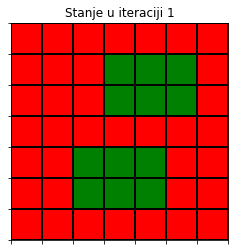

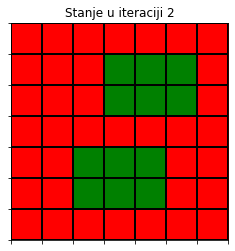

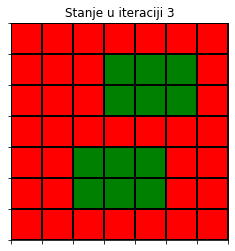

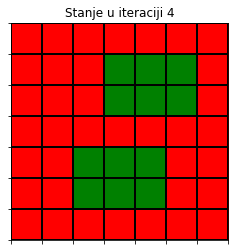

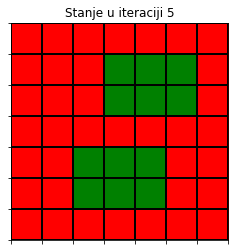

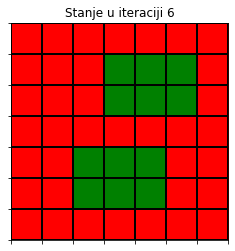

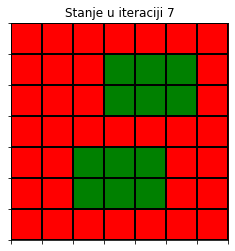

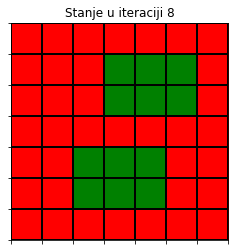

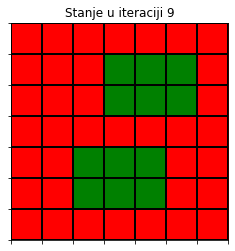

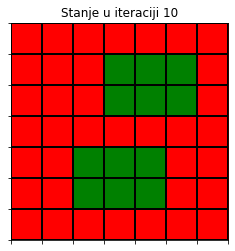

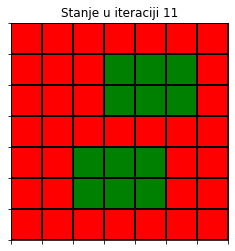

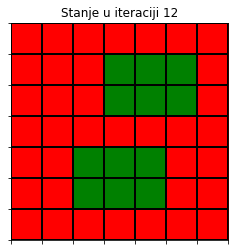

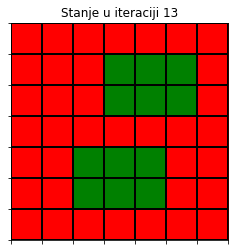

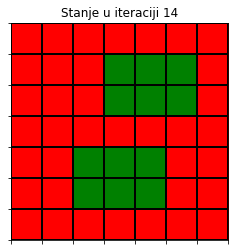

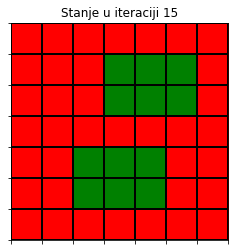

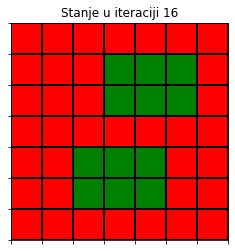

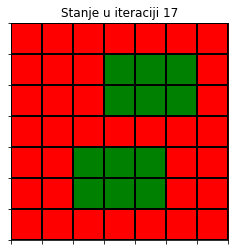

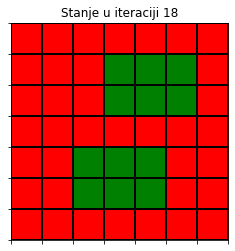

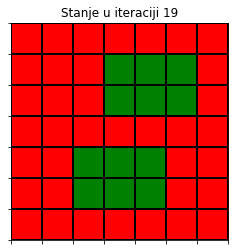

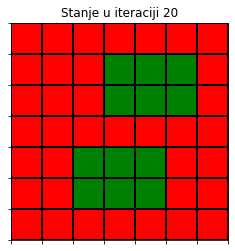

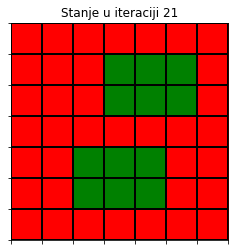

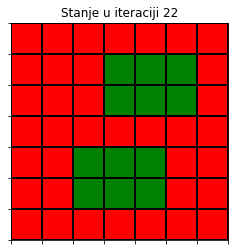

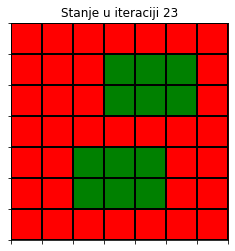

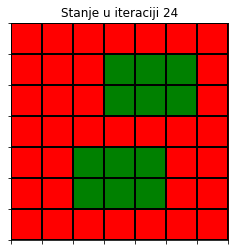

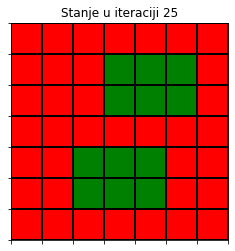

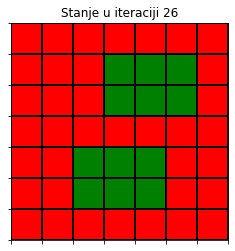

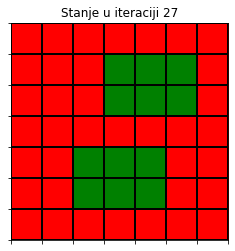

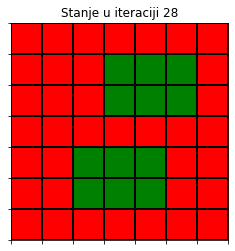

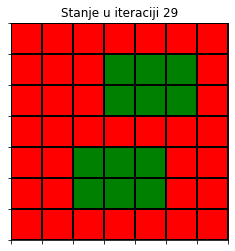

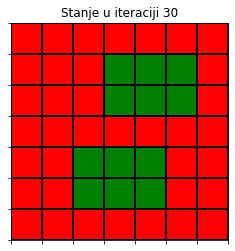

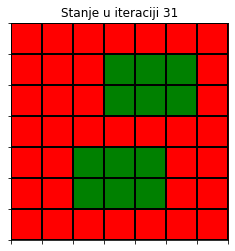

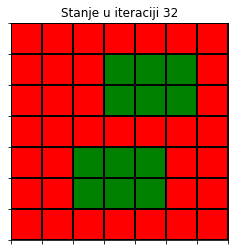

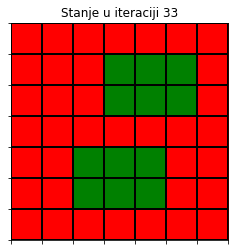

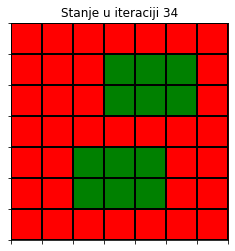

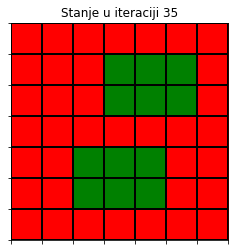

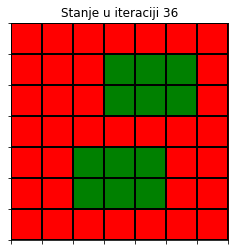

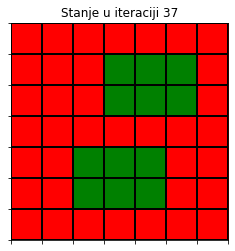

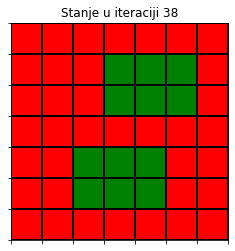

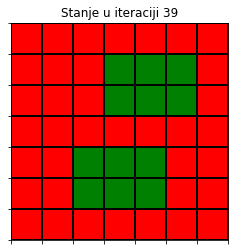

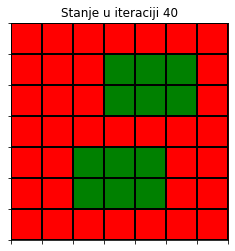

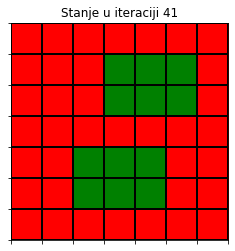

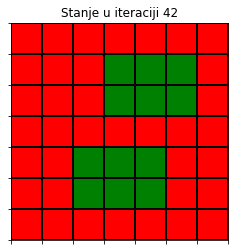

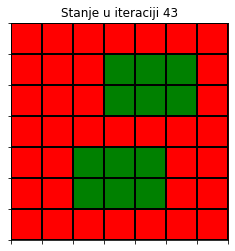

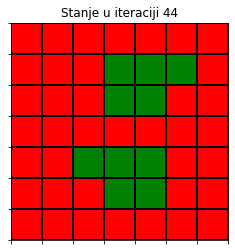

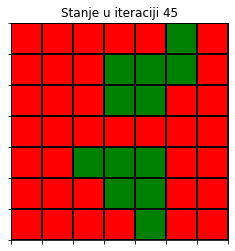

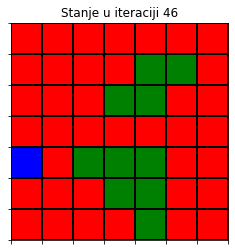

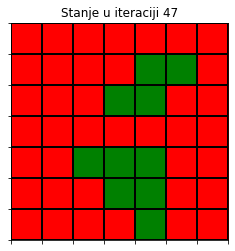

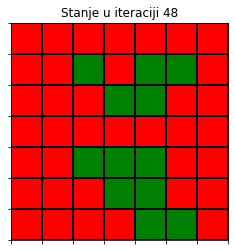

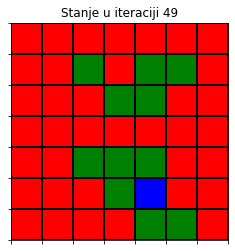

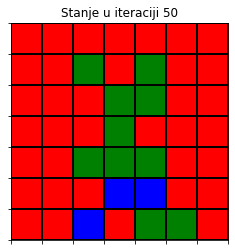

In [11]:
payoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state = [
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'T', 'T', 'T', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'T', 'T', 'T', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D']
]

num_of_iterations = 50

game = Game(payoff_values, n=7, initial_state=initial_state, num_of_iterations=num_of_iterations, mutation_rate=0.1, rate_of_senescence=40)
game.play_game()

for i in range(num_of_iterations):    
    plot_strategy_matrix(game, i + 1)

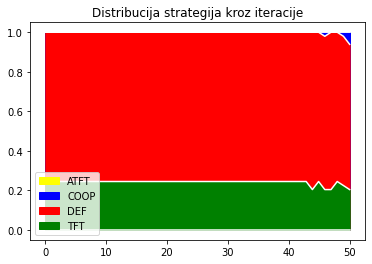

In [12]:
plot_strategy_ratio(game, 1, 1, 1, 'Distribucija strategija kroz iteracije')

## Slučajevi bez mutacije

Prvo gledamo kako će naše igre proći ako ne postoji mutacija, i ne postoji umiranje od starosti. Slučajeve koje želimo da posmatramo:

1. Sve četri strategija
2. DEF vs COOP
3. DEF vs TFT
4. DEF vs ATFT
5. COOP vs TFT
6. COOP vs ATFT
7. TFT vs ATFT
    
Pri čemu, svaka od strategija će donekle zauzeti istu količinu polja, da bi bilo fer.

**Inicijalizacija početnih parametara**, ovde dajemo vrednosti za T, R, P i S, tj. koliko će igrač dobiti poena na kraju partije.

In [13]:
odavdeodavdepayoff_values = {
    "T" : 2,
    "R" : 1,
    "P" : 0,
    "S" : -1
}

initial_state_1 = [
    ['x' for _ in range(10)]
    for _ in range(10)
]

for i in range(10):
    for j in range(10):
        prob = random.random()
        if prob < 0.25:
            initial_state_1[i][j] = 'C'
        elif prob < 0.5:
            initial_state_1[i][j] = 'D'
        elif prob < 0.75:
            initial_state_1[i][j] = 'T'
        else:
            initial_state_1[i][j] = 'A'
                
initial_state_2 = [
    ['D' if random.random() < 0.5 else 'C' for _ in range(10)]
    for _ in range(10)
]

initial_state_3 = [
    ['D' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_4 = [
    ['D' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_5 = [
    ['C' if random.random() < 0.5 else 'T' for _ in range(10)]
    for _ in range(10)
]

initial_state_6 = [
    ['C' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

initial_state_7 = [
    ['T' if random.random() < 0.5 else 'A' for _ in range(10)]
    for _ in range(10)
]

**Pokretanje igara**

In [14]:
# nismo slali mutation_rate i rate_of_senescence, jer su podrazumevani da ih nema!

game_1 = Game(payoff_values, n=10, initial_state=initial_state_1, num_of_iterations=100)
game_1.play_game()

game_2 = Game(payoff_values, n=10, initial_state=initial_state_2, num_of_iterations=100)
game_2.play_game()

game_3 = Game(payoff_values, n=10, initial_state=initial_state_3, num_of_iterations=100)
game_3.play_game()

game_4 = Game(payoff_values, n=10, initial_state=initial_state_4, num_of_iterations=100)
game_4.play_game()

game_5 = Game(payoff_values, n=10, initial_state=initial_state_5, num_of_iterations=100)
game_5.play_game()

game_6 = Game(payoff_values, n=10, initial_state=initial_state_6, num_of_iterations=100)
game_6.play_game()

game_7 = Game(payoff_values, n=10, initial_state=initial_state_7, num_of_iterations=100)
game_7.play_game()

**Plotovanje distribucija strategija kroz iteracije**

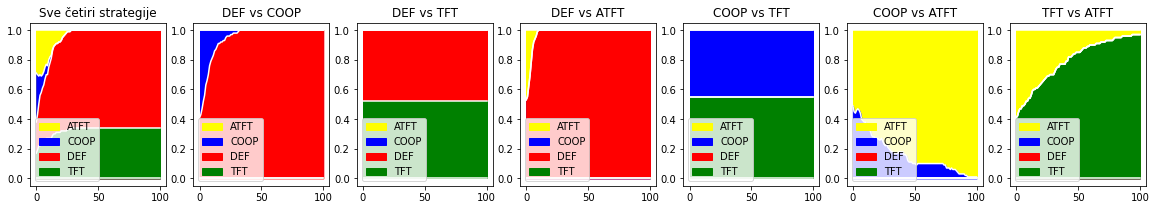

In [15]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(3)
plot_strategy_ratio(game_1, 1, 7, 1, 'Sve četiri strategije')
plot_strategy_ratio(game_2, 1, 7, 2, 'DEF vs COOP')
plot_strategy_ratio(game_3, 1, 7, 3, 'DEF vs TFT')
plot_strategy_ratio(game_4, 1, 7, 4, 'DEF vs ATFT')
plot_strategy_ratio(game_5, 1, 7, 5, 'COOP vs TFT')
plot_strategy_ratio(game_6, 1, 7, 6, 'COOP vs ATFT')
plot_strategy_ratio(game_7, 1, 7, 7, 'TFT vs ATFT')
plt.show()

Rezultate svakih od igara sa različitim strategijama možemo videti gore.
    
1. U ovoj igri, imali smo sve četiri strategije, i kao što možemo da vidimo, ATFT i COOP nestaju sa relativno malim brojem iteracija od DEF-a (što ima i smisla, jer će DEF zlopotrebiti COOP, a i ATFT će izgubiti od DEF, zato što će na njegove Defect, ATFT odgovarati sa Cooperate). Jednom kada DEF i ATFT nestanu stanje igre postaje stabilno.
2. Ovde tačno možemo da vidimo okolnosti opisane u 1. slučaju. COOP izgubi od DEF zbog gore navedenog razloga.
3. DEF vs TFT predstavlja jednu interesantnu situacije u kojoj imamo jedno stabilno stanje bez obzira na početnu konfiguraciju. Naime, jedina dinamika stanja je moguća u prvoj iteraciji, u kojoj se TFT ponaša isto kao i COOP.
4. Opet, ovo smo mogli da vidimo u slučaju 1., DEF je zloupotrebio to što ATFT uvek baca suprotno od njega, i osvojio je celu mapu vrlo brzo.
5. Trenutna okolnost je možda najbolji slučaj u kome COOP može da se nađe. Naime, TFT će da kažemo, "ponavljati ono što protivnik kaže", samim tim, se TFT-ovi ponašaju kao COOP, i sve je stabilno.
6. COOP će vrlo brzo gubiti protiv ATFT-a, jer se ATFT u ovoj okolnosti ponaša kao DEF.
7. U ovom slučaju ATFT gubi od FTF-a, kako će TFT naučiti kako protivnik igra dok će ATFT igrati suprotno od njega. Slično rezonovanje se može primeniti da je dobijeno da TFT gubi od ATFA-a. Ovaj slučaj je veoma interesantan, kako je moguće da popedi ili TFT ili ATFT, a to je potpuno neodređeno zbog stohastičnosti.

Funkcije koje primenjuje prezistentnu homologiju i kao rezultat iscrtava barkodove.

In [57]:
def barcode_generator(game_strategy_matrix, wanted_strategy):
    point_cloud = []
    n = len(game_strategy_matrix)
    for i in range(n):
        for j in range(n):
            if game_strategy_matrix[i][j] == wanted_strategy:
                point_cloud.append([i + 1, j + 1])
   
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=n * n)
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    
    gudhi.plot_persistence_barcode(diag)
    plt.show()    
    
def barcode_generator_over(game, start_iter, end_iter, wanted_strategy):
    point_cloud = []
    
    n = len(game.strategy_matrix_at_instance(1))
    for iteration in range(start_iter, end_iter + 1):
        game_strategy_matrix = game.strategy_matrix_at_instance(iteration)
        for i in range(n):
            for j in range(n):
                if game_strategy_matrix[i][j] == wanted_strategy:
                    point_cloud.append([i, j, iteration - start_iter + 1])

    max_edge_length=max(n, end_iter - start_iter)
    rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=max_edge_length, sparse=0.9)
    simplex_tree  = rips_complex.create_simplex_tree(max_dimension=3)
    diag = simplex_tree.persistence()

    filtered_diag = list(filter(lambda x: x[1][0] != 0.0 and x[1][1] != 1.0, diag))
    filtered_diag = list(filter(lambda x: x[1][0] != 1 and x[1][1] != 1.4142135623730951, filtered_diag))
    
    if filtered_diag != []:
      gudhi.plot_persistence_barcode(filtered_diag)
      plt.show()

      gudhi.plot_persistence_diagram(filtered_diag)
      plt.show() 
    else:
      gudhi.plot_persistence_barcode(diag)
      plt.show()

      gudhi.plot_persistence_diagram(diag)
      plt.show() 

    result_str = 'Rips complex is of dimension ' + repr(simplex_tree.dimension()) + ' - ' + \
    repr(simplex_tree.num_simplices()) + ' simplices - ' + \
    repr(simplex_tree.num_vertices()) + ' vertices.'
    print(result_str)

## Case (1) 

##### Bez mutacije i umiranja od starenja

U ovim slučaju imamo zamrznutno stanje.

In [42]:
initial_state_case_1 = [
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'T', 'T', 'T'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_1 = Game(payoff_values, n=7, initial_state=initial_state_case_1, num_of_iterations=25)
game_case_1.play_game()

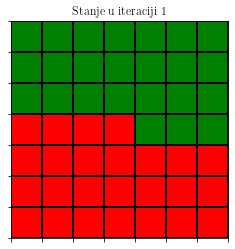

In [43]:
# ispisuje prvu iteraciju! (iteracije pocinju od 1!)
plot_strategy_matrix(game_case_1, 1) 

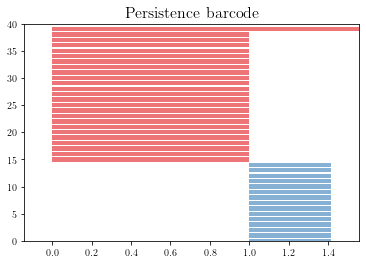

In [44]:
barcode_generator(game_case_1.strategy_matrix_at_instance(1), TypeOfStrategy.Defactor)

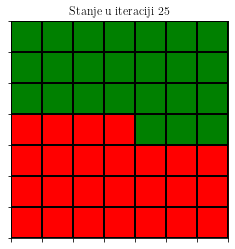

In [45]:
plot_strategy_matrix(game_case_1, 25) 

## Case (2) 

##### Bez mutacije i umiranja od starenja

U ovom slučaju stanje je dinamično do nekog trenutka nakon čega postaje postaje zamrznuto.

In [46]:
random.seed(42)

initial_state_case_2 = [
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'C', 'C', 'C', 'D'],
    [ 'D', 'D', 'D', 'C', 'C', 'C', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
    [ 'D', 'C', 'C', 'C', 'D', 'D', 'D'],
    [ 'D', 'C', 'C', 'C', 'D', 'D', 'D'],
    [ 'D', 'D', 'D', 'D', 'D', 'D', 'D'],
]

game_case_2 = Game(payoff_values, n=7, initial_state=initial_state_case_2, num_of_iterations=1000)
game_case_2.play_game()

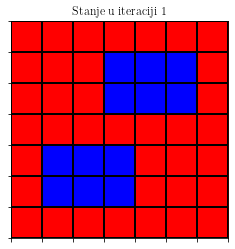

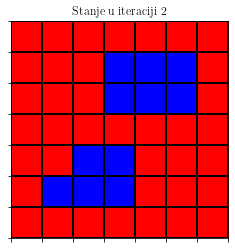

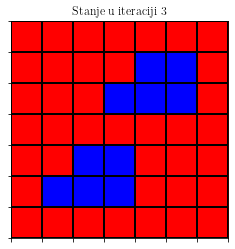

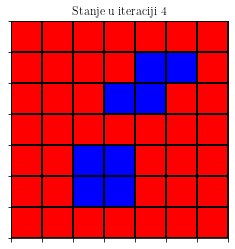

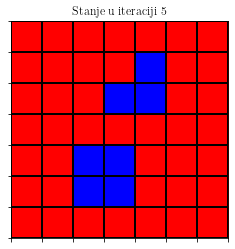

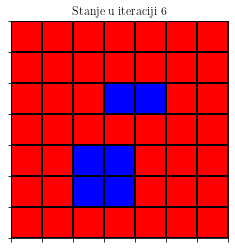

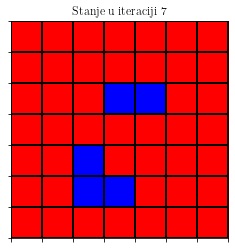

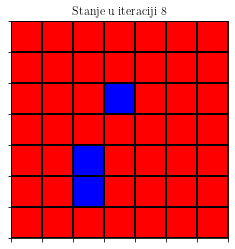

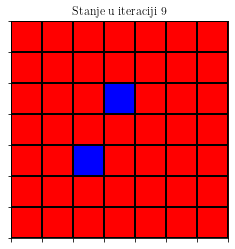

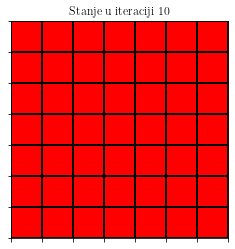

In [47]:
for i in range(10):
    plot_strategy_matrix(game_case_2, i + 1)

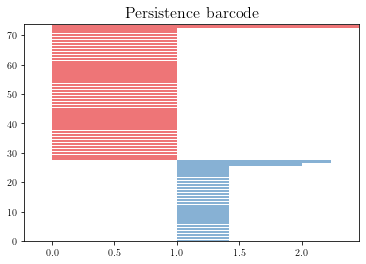

In [48]:
barcode_generator(game_case_2.strategy_matrix_at_instance(8), TypeOfStrategy.Defactor)

## Igra sa mutacijom, i umiranjem zbog starenja

In [49]:
random.seed(42)

initial_state_case_3 =[
    ['A', 'A', 'A', 'A', 'A', 'A', 'A'],
    ['A', 'A', 'A', 'A', 'A', 'T', 'T'],
    ['T', 'T', 'T', 'T', 'T', 'T', 'T'],
    ['T', 'T', 'T', 'D', 'D', 'D', 'D'],
    ['D', 'D', 'D', 'D', 'D', 'D', 'D'],
    ['D', 'C', 'C', 'C', 'C', 'C', 'C'],
    ['C', 'C', 'C', 'C', 'C', 'C', 'C'],
]

# for i in range(7):
#    for j in range(7):
#        prob = random.random()
#        if prob < 0.25:
#            initial_state_case_3[i][j] = 'C'
#        elif prob < 0.5:
#            initial_state_case_3[i][j] = 'D'
#        elif prob < 0.75:
#            initial_state_case_3[i][j] = 'T'
#        else:
#            initial_state_case_3[i][j] = 'A'
            
game_case_3 = Game(payoff_values, n=7, initial_state=None, num_of_iterations=1000, mutation_rate=0.05, rate_of_senescence=20)
game_case_3.play_game()

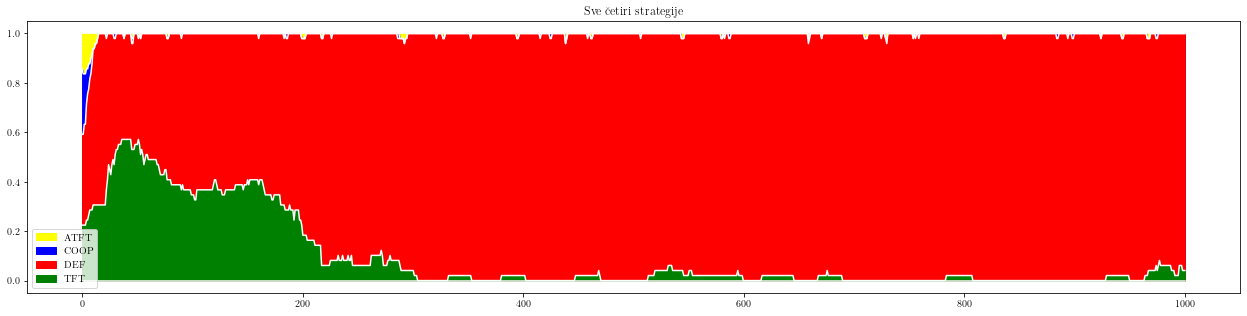

In [50]:
fig = plt.figure()
fig.set_figwidth(100)
fig.set_figheight(5)
plot_strategy_ratio(game_case_3, 1, 4, 1, 'Sve četiri strategije')
plt.show()

## Case (3)

##### Sa mutacijom, i umiranjem zbog starenja

U ovom slučaju imamo stabilno stanje gde nastaje revolucija TFT-a i ATFT-a. Perzistentna homologija je otkrila te dve revolucije koje su ugašene.

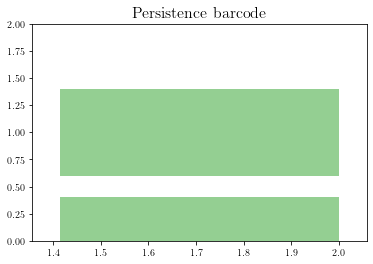

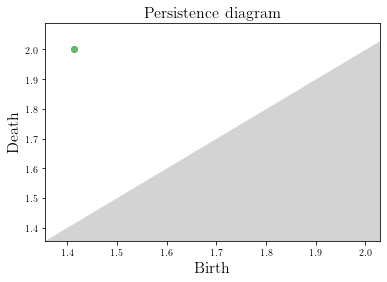

Rips complex is of dimension 3 - 9071336 simplices - 1201 vertices.


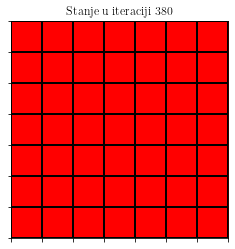

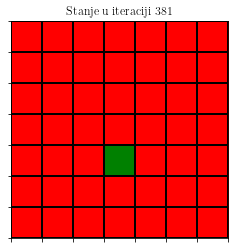

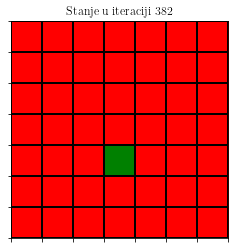

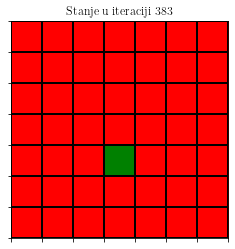

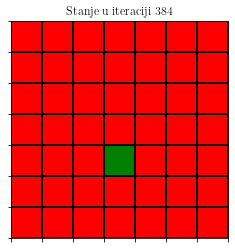

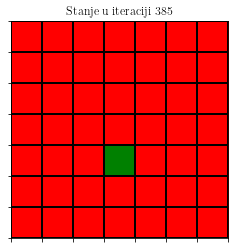

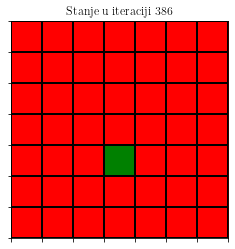

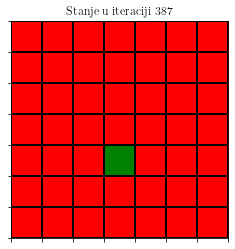

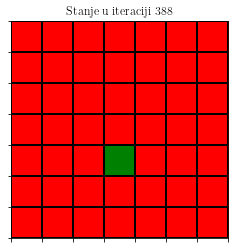

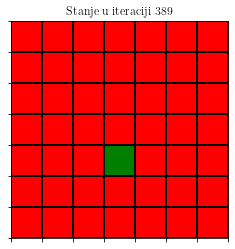

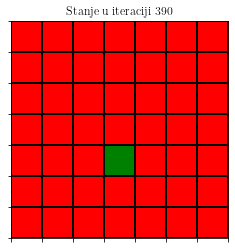

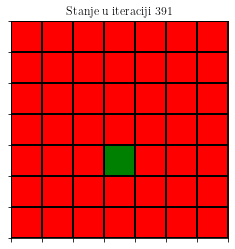

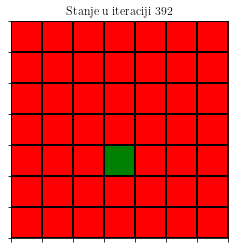

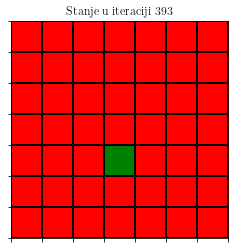

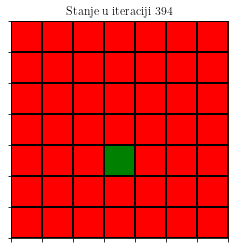

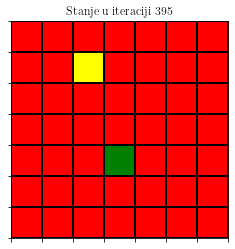

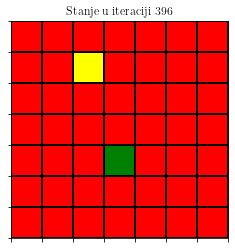

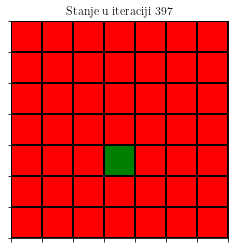

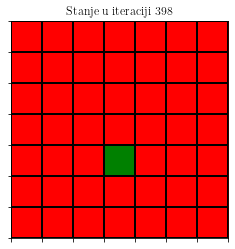

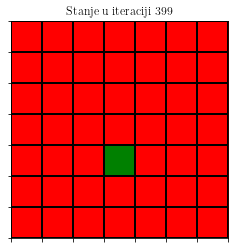

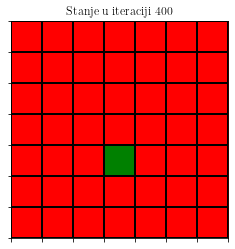

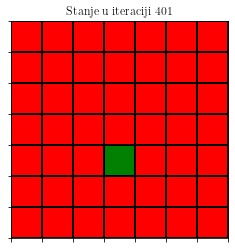

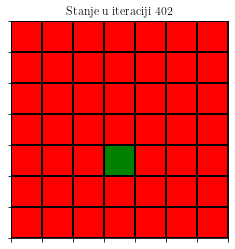

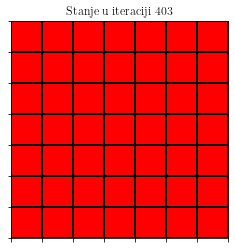

In [68]:
barcode_generator_over(game_case_3, 380, 404, TypeOfStrategy.Defactor)
for i in range(380, 404):
    plot_strategy_matrix(game_case_3, i)

# Case (4)

##### Sa mutacijom, i umiranjem zbog starenja

U ovom slučaju imamo da iz stabilnog stanja, gde su sve strategije DEF, dobijamo radjanje dve nove strategije TFT i ATFT. TFT ne umire u posmatranom rasponu, dok ATFT živi samo 2 iteracije. Zbog toga imamo samo jedan dvodimenzioni barkod.

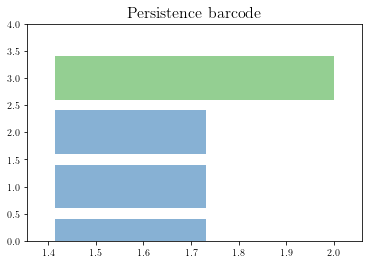

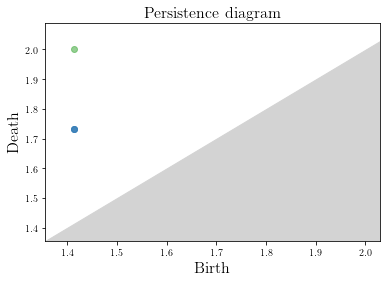

Rips complex is of dimension 3 - 1102570 simplices - 378 vertices.


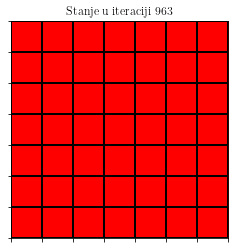

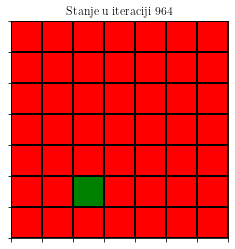

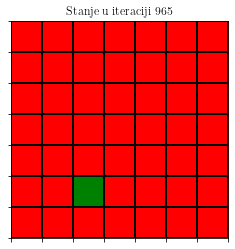

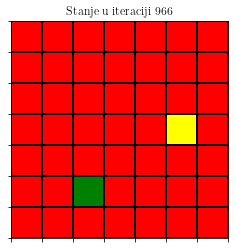

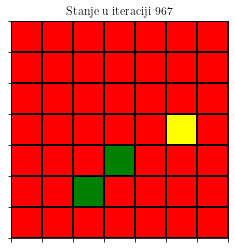

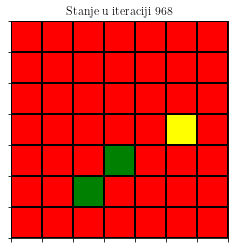

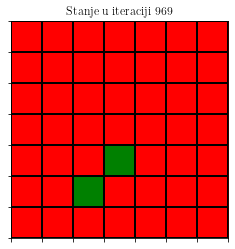

In [67]:
barcode_generator_over(game_case_3, 963, 970, TypeOfStrategy.Defactor)
for i in range(963, 970):
    plot_strategy_matrix(game_case_3, i)

# Zakljucak i diskusija

Perzistentna homologija nam omogućava istraživanje prostornih igara na potpuno novi način. Naime, perzistentna homologija pruža rigorozne matematičke okvire za istraživanje prostora, koji su pri tome otporni na šum. U nekim slučajevima perzistentna homologija može se koristiti za definisanje nekih osobina, dok sa druge strane može da prepoznaje unapred definisana osobina nekog prostora, gde je prostor predstavljen 2D rešetkom. Takođe, videli smo da je, uz male poteškoće pri računanju, moguće posmatrati neki interval stanja 2D rešetke i analizirati promene koje nastaju kroz vreme.

U ovom radu je analizirana samo igra zatvorenikova dilema, gde dva igrača mogu imati jednu od četiri strategija COOP, DEF, TFT, ATFT. Postavlja se pitanje da li je moguće da se perzistentna homologija primeni na drugim verzijama igre zatvorenikova dilema, ili čak na nekim drugim prostornim igrama kao što je Džon Konvejova igra života.